<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Introduction to Dask

In this lesson, we discuss cover the basics of Dask. Our learning goals are as
follows. By the end of the lesson, we will be able to:

- Identify and describe Dask Collections (Array, DataFrame) and Schedulers
- Work with Dask Array's in much the same way you would work with a NumPy array
- Understand some of the tradeoffs surounding chunk size, chunk shape, and
  computational overhead
- Deploy a local Dask Distributed Cluster and access the diagnostics dashboard

## Table of contents

1. [**What-is-Dask?**](#What-is-Dask?)
1. [**Dask Collections**](#Dask-Collections)
1. [**Parallelism using the dask.distributed scheduler**](#Parallelism-using-the-dask.distributed-scheduler)
1. [**Profiling & Diagnostics using the Dask Dashboard**](#Profiling-&-Diagnostics-using-the-Dask-Dashboard)
1. [**Distributed Dask clusters for HPC and Cloud environments**](#Distributed-Dask-clusters-for-HPC-and-Cloud-environments)

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

## What is Dask?

Dask is a flexible parallel computing library for analytic computing. Dask
provides dynamic parallel task scheduling and high-level big-data collections
like `dask.array` and `dask.dataframe`, and an extensive suite of deployment
options. Dask's documentation can be found here:
https://docs.dask.org/en/latest/

<img src="https://docs.dask.org/en/latest/_images/dask-overview.svg" 
     width="75%" 
     align=center
     alt="Dask overview">

## Quick setup

For the purposes of this notebook, we'll use a Dask Cluster to manage
computations. The next cell sets up a simple LocalCluster. We'll cover Dask
schedulers and clusters later on in this notebook.


In [1]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:34291 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.67 GB


<p>&#128070</p> Click the Dashboard link above.


## Dask Collections

Dask includes 3 main collections:

- [Dask Array](https://docs.dask.org/en/latest/array.html): Parallel NumPy
  arrays
- [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html): Parallel
  Pandas DataFrames
- [Dask Bag](https://docs.dask.org/en/latest/bag.html): Parallel Python Lists

Xarray primarily interfaces with the Dask Array collection so we'll skip the
others for now. You can find out more about Dask's user interfaces
[here](https://docs.dask.org/en/latest/user-interfaces.html).


## Dask Arrays

Dask Array implements a subset of the NumPy ndarray interface using blocked
algorithms, cutting up the large array into many small arrays. This lets us
compute on arrays larger than memory using multiple cores. We coordinate these
blocked algorithms using Dask graphs. Dask Array's are also _lazy_, meaning that
they do not evaluate until you explicitly ask for a result using the `compute`
method.

If we want to create a NumPy array of all ones, we do it like this:


In [2]:
import numpy as np

shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

This array contains exactly 32 MB of data:


In [3]:
print("%.1f MB" % (ones_np.nbytes / 1e6))

32.0 MB


Now let's create the same array using Dask's array interface.


In [4]:
import dask.array as da

ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

This works, but we didn't tell Dask how to split up (or chunk) the array, so it
is not optimized for parallel computation.

A crucal difference with Dask is that we must specify the `chunks` argument.
"Chunks" describes how the array is split up over many sub-arrays.

![Dask Arrays](http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg)
_source:
[Dask Array Documentation](http://dask.pydata.org/en/latest/array-overview.html)_

There are
[several ways to specify chunks](http://dask.pydata.org/en/latest/array-creation.html#chunks).
In this lecture, we will use a block shape.


In [5]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Notice that we just see a symbolic represetnation of the array, including its
shape, dtype, and chunksize. No data has been generated yet. When we call
`.compute()` on a Dask array, the computation is trigger and the dask array
becomes a numpy array.


In [6]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In order to understand what happened when we called `.compute()`, we can
visualize the Dask _graph_, the symbolic operations that make up the array


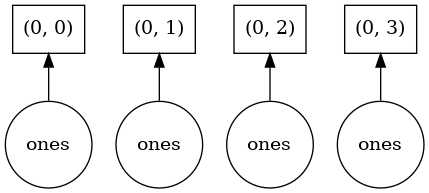

In [7]:
ones.visualize()

Our array has four chunks. To generate it, Dask calls `np.ones` four times and
then concatenates this together into one array.

Rather than immediately loading a Dask array (which puts all the data into RAM),
it is more common to reduce the data somehow. For example:


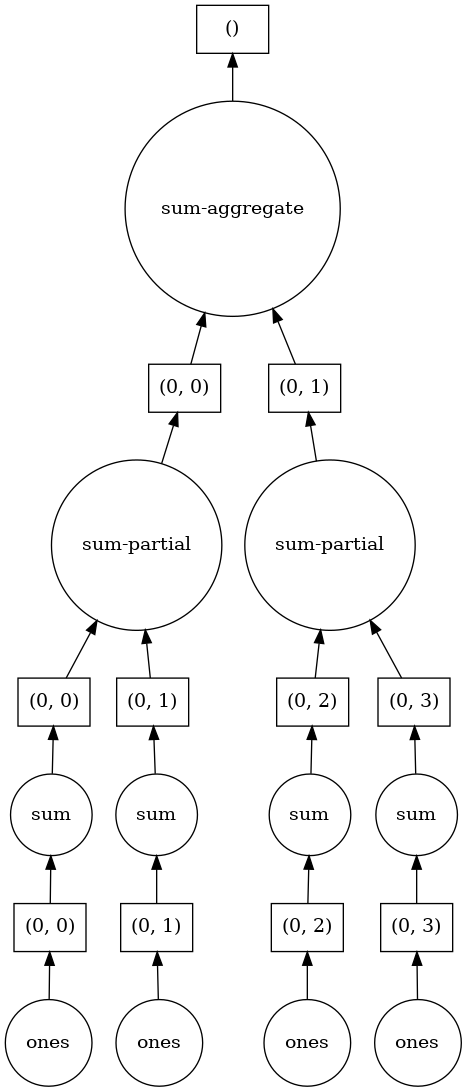

In [8]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

### Exercise

Modify the chunk size (or shape) in the `ones` array and visualize how the task
graph changes.


In [ ]:
# your code here

Here we see Dask's strategy for finding the sum. This simple example illustrates
the beauty of Dask: it automatically designs an algorithm appropriate for custom
operations with big data.

If we make our operation more complex, the graph gets more complex.


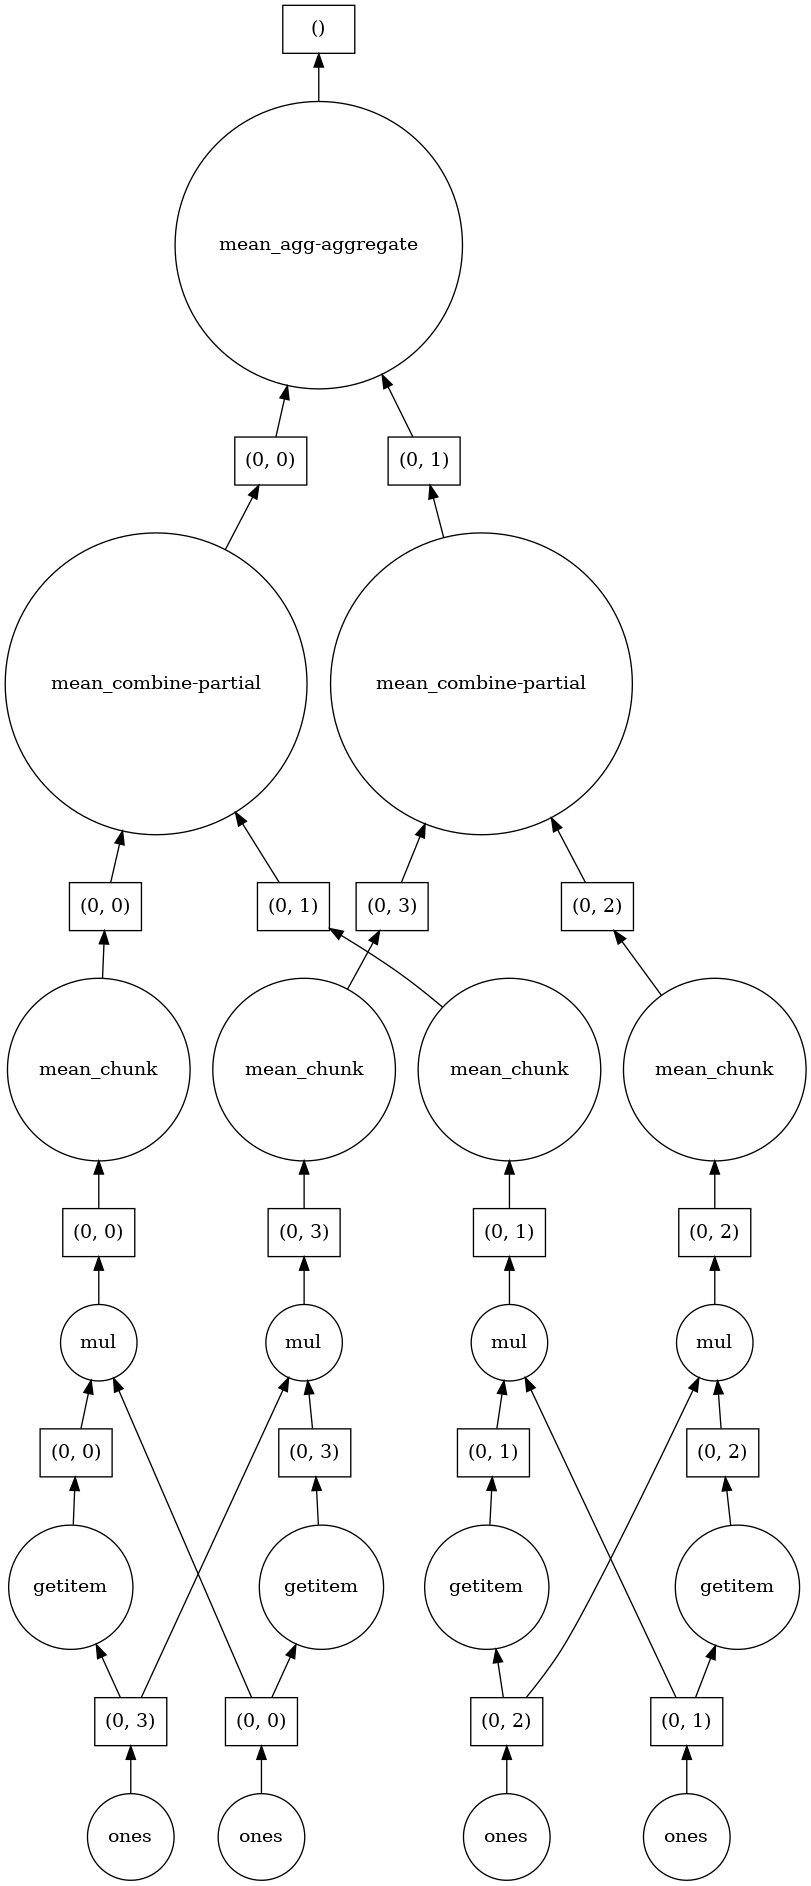

In [9]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (32 MB) is probably not big
enough to warrant the use of Dask.

We can make it a lot bigger!


In [10]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

,Array,Chunk
Bytes,6.40 GB,8.00 MB
Shape,"(200000, 4000)","(1000, 1000)"
Count,800 Tasks,800 Chunks
Type,float64,numpy.ndarray


In [11]:
print("%.1f MB" % (big_ones.nbytes / 1e6))

6400.0 MB


This dataset is 6.4 GB, rather than 32 MB! This is probably close to or greater
than the amount of available RAM than you have in your computer. Nevertheless,
Dask has no problem working on it.

_Do not try to `.visualize()` this array!_

When doing a big calculation, dask also has some tools to help us understand
what is happening under the hood. Let's watch the dashboard again as we do a
bigger computation.


In [12]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

result = big_calc.compute()
result

1.0

### Reduction

All the usual numpy methods work on dask arrays. You can also apply numpy
function directly to a dask array, and it will stay lazy.


In [13]:
big_ones_reduce = (np.cos(big_ones) ** 2).mean(axis=1)
big_ones_reduce

,Array,Chunk
Bytes,1.60 MB,8.00 kB
Shape,"(200000,)","(1000,)"
Count,3400 Tasks,200 Chunks
Type,float64,numpy.ndarray


Plotting also triggers computation, since we need the actual values


In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

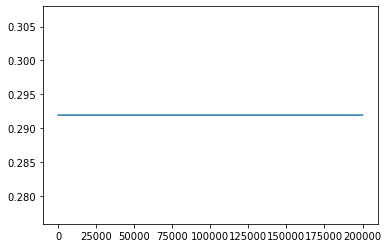

In [15]:
plt.plot(big_ones_reduce)

## Parallelism using the dask.distributed scheduler

In the [first cell](#Quick-setup) of this notebook, we started a local Dask
Cluster and Client. We skipped past some important details there that we'll
unpack now.

### Dask Schedulers

The Dask _Schedulers_ orchestrate the tasks in the Task Graphs so that they can
be run in parallel. _How_ they run in parallel, though, is determined by which
_Scheduler_ you choose.

There are 3 _local_ schedulers:

- **Single-Thread Local:** For debugging, profiling, and diagnosing issues
- **Multi-threaded:** Using the Python built-in `threading` package (the default
  for all Dask operations except `Bags`)
- **Multi-process:** Using the Python built-in `multiprocessing` package (the
  default for Dask `Bags`)

and 1 _distributed_ scheduler, which we will talk about later:

- **Distributed:** Using the `dask.distributed` module (which uses `tornado` for
  communication over TCP). The distributed scheduler uses a `Cluster` to manage
  communication between the scheduler and the "workers". This is described in
  the next section.

### Distributed Clusters (http://distributed.dask.org/)

- `LocalCluster` - Creates a `Cluster` that can be executed locally. Each
  `Cluster` includes a `Scheduler` and `Worker`s.
- `Client` - Connects to and drives computation on a distributed `Cluster`


## Profiling & Diagnostics using the Dask Dashboard

You'll recall from above, that we opened a url to the Dask Dashboard:


In [16]:
client

Client Scheduler: tcp://127.0.0.1:34291 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.67 GB


The dashboard the Dask distributed scheduler provides a an incredibly valuable
tool for gaining insights into the performance of your computation and the
cluster as a whole. In the dashboard, you'll see a number of tags:

- _Status_: Overview of the current state of the scheduler, including the active
  task stream, progress, memory per worker, and the number of tasks per worker.
- _Workers_: The workers tab allows you to track cpu and memory use per worker.
- _System_: Live tracking of system resources like cpu, memory, bandwidth, and
  open file descriptors
- _Profile_: Fine-grained statistical profiling
- _Info_: Worker status and logs.

Another useful diagnostic tool is Dask's static performance report. This allows
you to save a report, including the task stream, worker profiles, etc. for all
or a specific part of a workflow. Below is an example of how you would create
such a report:


In [17]:
from dask.distributed import performance_report

with performance_report(filename="dask-report.html"):
    big_calc.compute()

### Exercise

Again, let's modify the chunk size in `big_ones` (aim for ~100mb). How does the
_Performance Report_ change with a larger chunk size?


In [ ]:
# your code here

with performance_report(filename="dask-report-large-chunk.html"):
    big_calc.compute()

## Distributed Dask clusters for HPC and Cloud environments

Dask can be deployed on distributed infrastructure, such as a an HPC system or a
cloud computing system. There is a growing ecosystem of Dask deployment projects
that faciliate easy deployment and scaling of Dask clusters on a wide variety of
computing systems.

### HPC

#### Dask Jobqueue (https://jobqueue.dask.org/)

- `dask_jobqueue.PBSCluster`
- `dask_jobqueue.SlurmCluster`
- `dask_jobqueue.LSFCluster`
- etc.

#### Dask MPI (https://mpi.dask.org/)

- `dask_mpi.initialize`

### Cloud

#### Dask Kubernetes (https://kubernetes.dask.org/)

- `dask_kubernetes.KubeCluster`

#### Dask Cloud Provider (https://cloudprovider.dask.org)

- `dask_cloudprovider.FargateCluster`
- `dask_cloudprovider.ECSCluster`
- `dask_cloudprovider.ECSCluster`

#### Dask Gateway (https://gateway.dask.org/)

- `dask_gateway.GatewayCluster`


---

_Note: Pieces of this notebook comes from the following sources:_

- https://github.com/pangeo-data/pangeo-tutorial
- https://github.com/rabernat/research_computing
- https://github.com/dask/dask-examples
